# Modelling

In [1]:
pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score, roc_auc_score

import warnings
warnings.filterwarnings('ignore')

from sklearn.tree import export_graphviz
from IPython.display import Image
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.inspection import permutation_importance

In [3]:
#upload data
data = pd.read_csv('our-data/data_variance_threshold_output.csv', index_col=0)
data = data.dropna()
#Sorting values for time series cross validation
data = data.sort_values('YearOfContactDate')
data

,YearOfContactDate,AsthmaDiagnosisAge0to17Per100>10,Black or African American Population,Pre1950,Median Income,CSMOKING_CrudePrev,White Population,"Particulate Matter, Condensable",Carbon Monoxide,OBESITY_CrudePrev,ACCESS2_CrudePrev,BPHIGH_CrudePrev,Median Age,DIABETES_CrudePrev,CHOLSCREEN_CrudePrev,COPD_CrudePrev,Age0to17PopEst2015_19ACS_x,NumberED_VisitsAge0to17Per100,NumberAsthmaRelatedED_VisitsPer100,NumberAcuteRespiratoryTractInfectionRelatedED_VisitsAge0to17Per100
Geo_FIPS,,,,,,,,,,,,,,,,,,,,
564500,2016.0,0,27.0,0.426657,64456.0,19.9,2918.0,131.112692,1112.874314,32.6,8.3,31.0,45.0,10.1,86.6,7.5,590.0,12.203390,0.008475,1.016949
70600,2016.0,1,46.0,0.422666,48719.0,12.8,1621.0,0.805679,11.996027,20.7,7.5,19.8,29.6,4.7,65.1,2.9,108.0,0.000000,0.000000,0.000000
90300,2016.0,1,230.0,0.823293,37372.0,25.0,1412.0,1.285792,22.382408,31.1,15.6,30.3,31.9,10.0,68.6,7.7,113.0,0.000000,0.000000,0.000000
401100,2016.0,0,114.0,0.307229,55154.0,20.6,4436.0,62.849825,443.653499,32.5,9.0,32.7,43.3,10.9,87.2,8.4,923.0,13.542795,0.014085,0.866739
401200,2016.0,1,26.0,0.617838,30556.0,27.2,2813.0,48.180000,340.100000,37.7,12.6,35.6,44.7,13.7,83.3,11.4,663.0,27.601810,0.081448,4.675716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
476100,2019.0,0,250.0,0.261860,54884.0,18.5,4271.0,0.000000,0.124842,30.4,8.5,29.0,39.2,8.7,85.2,6.4,964.0,25.311203,0.020747,4.875519
476200,2019.0,0,28.0,0.282306,73403.0,18.7,3007.0,0.000000,0.120028,31.5,7.9,32.1,46.2,9.6,86.4,7.1,433.0,17.551963,0.018476,2.078522
477100,2019.0,0,11.0,0.214669,82904.0,15.4,3100.0,0.000000,0.106616,30.1,6.7,34.2,49.5,10.2,89.0,7.1,618.0,23.624595,0.037217,3.074434


In [4]:
#target summary
data['AsthmaDiagnosisAge0to17Per100>10'].describe() 

count    1556.000000
mean        0.258997
std         0.438225
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: AsthmaDiagnosisAge0to17Per100>10, dtype: float64

In [5]:
#target variable
data['HighDiagnosisRate'] = data['AsthmaDiagnosisAge0to17Per100>10']==1
data['HighDiagnosisRate']
data.head()

,YearOfContactDate,AsthmaDiagnosisAge0to17Per100>10,Black or African American Population,Pre1950,Median Income,CSMOKING_CrudePrev,White Population,"Particulate Matter, Condensable",Carbon Monoxide,OBESITY_CrudePrev,...,BPHIGH_CrudePrev,Median Age,DIABETES_CrudePrev,CHOLSCREEN_CrudePrev,COPD_CrudePrev,Age0to17PopEst2015_19ACS_x,NumberED_VisitsAge0to17Per100,NumberAsthmaRelatedED_VisitsPer100,NumberAcuteRespiratoryTractInfectionRelatedED_VisitsAge0to17Per100,HighDiagnosisRate
Geo_FIPS,,,,,,,,,,,,,,,,,,,,,
564500,2016.0,0,27.0,0.426657,64456.0,19.9,2918.0,131.112692,1112.874314,32.6,...,31.0,45.0,10.1,86.6,7.5,590.0,12.203390,0.008475,1.016949,False
70600,2016.0,1,46.0,0.422666,48719.0,12.8,1621.0,0.805679,11.996027,20.7,...,19.8,29.6,4.7,65.1,2.9,108.0,0.000000,0.000000,0.000000,True
90300,2016.0,1,230.0,0.823293,37372.0,25.0,1412.0,1.285792,22.382408,31.1,...,30.3,31.9,10.0,68.6,7.7,113.0,0.000000,0.000000,0.000000,True
401100,2016.0,0,114.0,0.307229,55154.0,20.6,4436.0,62.849825,443.653499,32.5,...,32.7,43.3,10.9,87.2,8.4,923.0,13.542795,0.014085,0.866739,False
401200,2016.0,1,26.0,0.617838,30556.0,27.2,2813.0,48.180000,340.100000,37.7,...,35.6,44.7,13.7,83.3,11.4,663.0,27.601810,0.081448,4.675716,True


In [6]:
#setting feature matrix and target
X = data.drop(['HighDiagnosisRate','AsthmaDiagnosisAge0to17Per100>10'],axis=1)
y = data['HighDiagnosisRate']

In [7]:
#create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape

((1244, 19), (312, 19))

In [8]:
y.mean()*100  # percent

25.89974293059126

In [9]:
# Time series CV
tscv = TimeSeriesSplit(n_splits = 4)

# I removed imputer from here, because the features data does not having missing values
# Creating preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('scaler', StandardScaler())
        ]), list(X.columns))])

# Model 1: Logistic Regression

In [10]:
#Creating modeling pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(random_state=42))
])

param_grid = [{
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'classifier__C': np.logspace(-4, 4, 20),
    'classifier__solver': ['lbfgs', 'newton-cg', 'liblinear', 'sag', 'saga'],
    'classifier__max_iter': [100, 1000, 2500, 5000]
}]

In [11]:
grid_search = GridSearchCV (
    estimator  = model_pipeline,
    param_grid = param_grid,  # Use demo_param_grid for quicker execution
            cv = tscv,
    #scoring='precision_recall_curve',
         refit = 'PR_AUC',  # Refit based on PR AUC
        n_jobs = -1,
       verbose = 2,
    return_train_score=True,
    scoring={
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'roc_auc': 'roc_auc',
        'PR_AUC': 'average_precision'  # PR AUC score
    }
)

In [12]:
print("\nStarting grid search...")
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("\nBest parameters:")
print(grid_search.best_params_)
print(f"\nBest cross-validation score: {grid_search.best_score_:.4f}")

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("\nTest Set Evaluation:")
print(classification_report(y_test, y_pred))


Starting grid search...
Fitting 4 folds for each of 1600 candidates, totalling 6400 fits

Best parameters:
{'classifier__C': 0.23357214690901212, 'classifier__max_iter': 2500, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}

Best cross-validation score: 0.6167

Test Set Evaluation:
              precision    recall  f1-score   support

       False       0.85      0.75      0.80       231
        True       0.46      0.62      0.53        81

    accuracy                           0.71       312
   macro avg       0.66      0.68      0.66       312
weighted avg       0.75      0.71      0.73       312



Text(0.5, 1.0, 'Confusion Matrix')

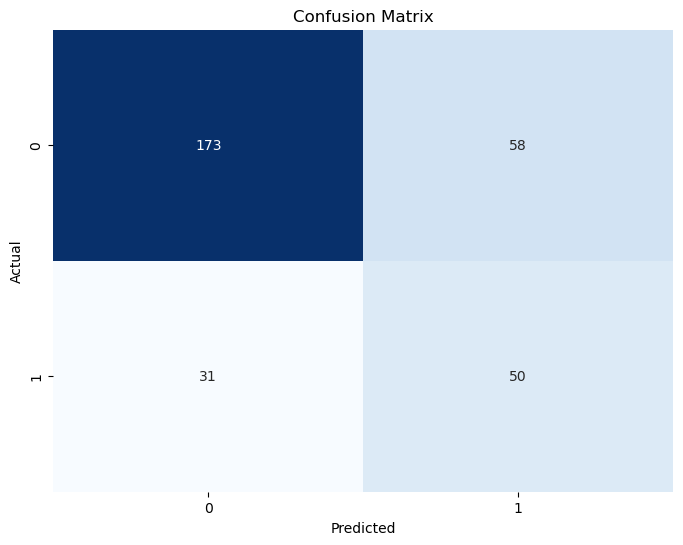

In [13]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

In [14]:
roc_auc = roc_auc_score(y_test, y_prob)
roc_auc

0.7407941852386296

In [15]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
pr_auc

0.5757593076320686

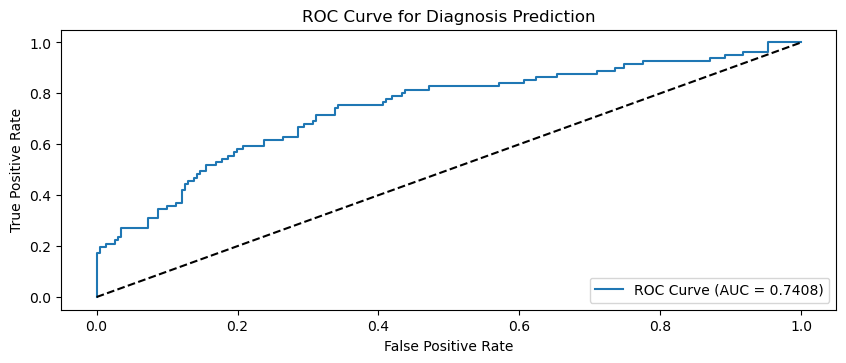

In [16]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Diagnosis Prediction')
plt.legend(loc='lower right')

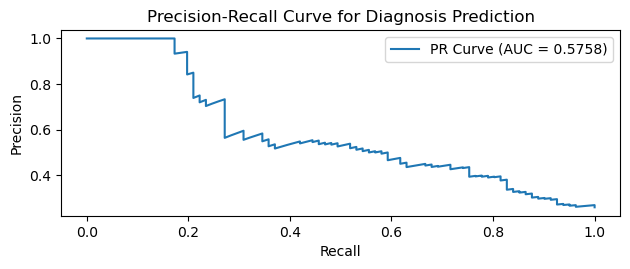

In [17]:
plt.subplot(2, 1, 2)
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Diagnosis Prediction')
plt.legend(loc='upper right')
plt.tight_layout()

In [18]:
# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Fit logistic regression on SMOTE data
clf_smote = LogisticRegression(random_state=42)
clf_smote.fit(X_train_smote, y_train_smote)

# Predict probabilities for SMOTE model
y_proba_smote = clf_smote.predict_proba(X_test)

In [19]:
def evaluate_model( msg, X_test, y_test, y_pred, y_proba ):
    w=18
    print(msg, '\n')
    cm = confusion_matrix(y_test, y_pred)
    
    print( cm ); print()
    print( f'%{w}s : %.4f' % ('Precision', precision_score(y_test, y_pred)))
    print( f'%{w}s : %.4f' % ('Recall', recall_score(y_test, y_pred)))
    print( f'%{w}s : %.4f' % ('F1 Score', f1_score(y_test, y_pred)))
    print( f'%{w}s : %.4f' % ('AUC-ROC', roc_auc_score(y_test, y_prob)))
    print( f'%{w}s : %.4f' % ('Average Precision', average_precision_score( y_test, y_prob)))
    print()
evaluate_model('SMOTE Model Performance', X_test, y_test, y_pred, y_prob)

SMOTE Model Performance 

[[173  58]
 [ 31  50]]

         Precision : 0.4630
            Recall : 0.6173
          F1 Score : 0.5291
           AUC-ROC : 0.7408
 Average Precision : 0.5781



In [20]:
#Random undersampling

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# Check new class distribution
print(f"\nAfter Undersampling - Training examples: {len(X_train_rus)}")
print(f"Class distribution: {np.bincount(y_train_rus)}")


After Undersampling - Training examples: 644
Class distribution: [322 322]


In [21]:
#Train model with undersampling

clf_rus = grid_search.best_estimator_
clf_rus.fit(X_train_rus, y_train_rus)
y_pred_rus = clf_rus.predict(X_test)
y_proba_rus = clf_rus.predict_proba(X_test)

In [22]:
#Evaluate undersampling model, does worse except for recall

evaluate_model('Undersample Model Performance', X_test, y_test, y_pred_rus, y_proba_rus )

Undersample Model Performance 

[[173  58]
 [ 31  50]]

         Precision : 0.4630
            Recall : 0.6173
          F1 Score : 0.5291
           AUC-ROC : 0.7408
 Average Precision : 0.5781



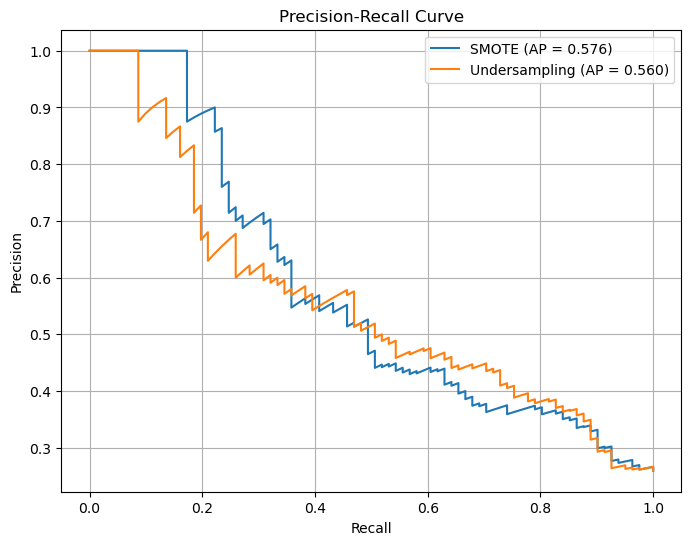

In [23]:
#Plotting Prescision-Recall Curve for all models

plt.figure(figsize=(8, 6))

# SMOTE model PR curve
precision_smote, recall_smote, _ = precision_recall_curve(y_test, y_proba_smote[:, 1])
ap_smote = average_precision_score(y_test, y_proba_smote[:, 1])
plt.plot(recall_smote, precision_smote, label=f'SMOTE (AP = {ap_smote:.3f})')

# Undersampling model PR curve (y_proba_rus must be defined)
precision_rus, recall_rus, _ = precision_recall_curve(y_test, y_proba_rus[:, 1])
ap_rus = average_precision_score(y_test, y_proba_rus[:, 1])
plt.plot(recall_rus, precision_rus, label=f'Undersampling (AP = {ap_rus:.3f})')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

YearOfContactDate: 0.13301511696861937
Black or African American Population: 0.36975393310755084
Pre1950: 0.0
Median Income: 0.15178643116611948
CSMOKING_CrudePrev: 0.11941482315741067
White Population: 0.0
Particulate Matter, Condensable: 0.1854496194288239
Carbon Monoxide: 0.42678731146256205
OBESITY_CrudePrev: 0.0
ACCESS2_CrudePrev: 0.0
BPHIGH_CrudePrev: 0.033145787175786014
Median Age: 0.016371680766133136
DIABETES_CrudePrev: 0.0
CHOLSCREEN_CrudePrev: 0.3109851669981354
COPD_CrudePrev: 0.025335468801514084
Age0to17PopEst2015_19ACS_x: 0.5973147221300287
NumberED_VisitsAge0to17Per100: 1.6150146192935537
NumberAsthmaRelatedED_VisitsPer100: 0.0
NumberAcuteRespiratoryTractInfectionRelatedED_VisitsAge0to17Per100: 0.0


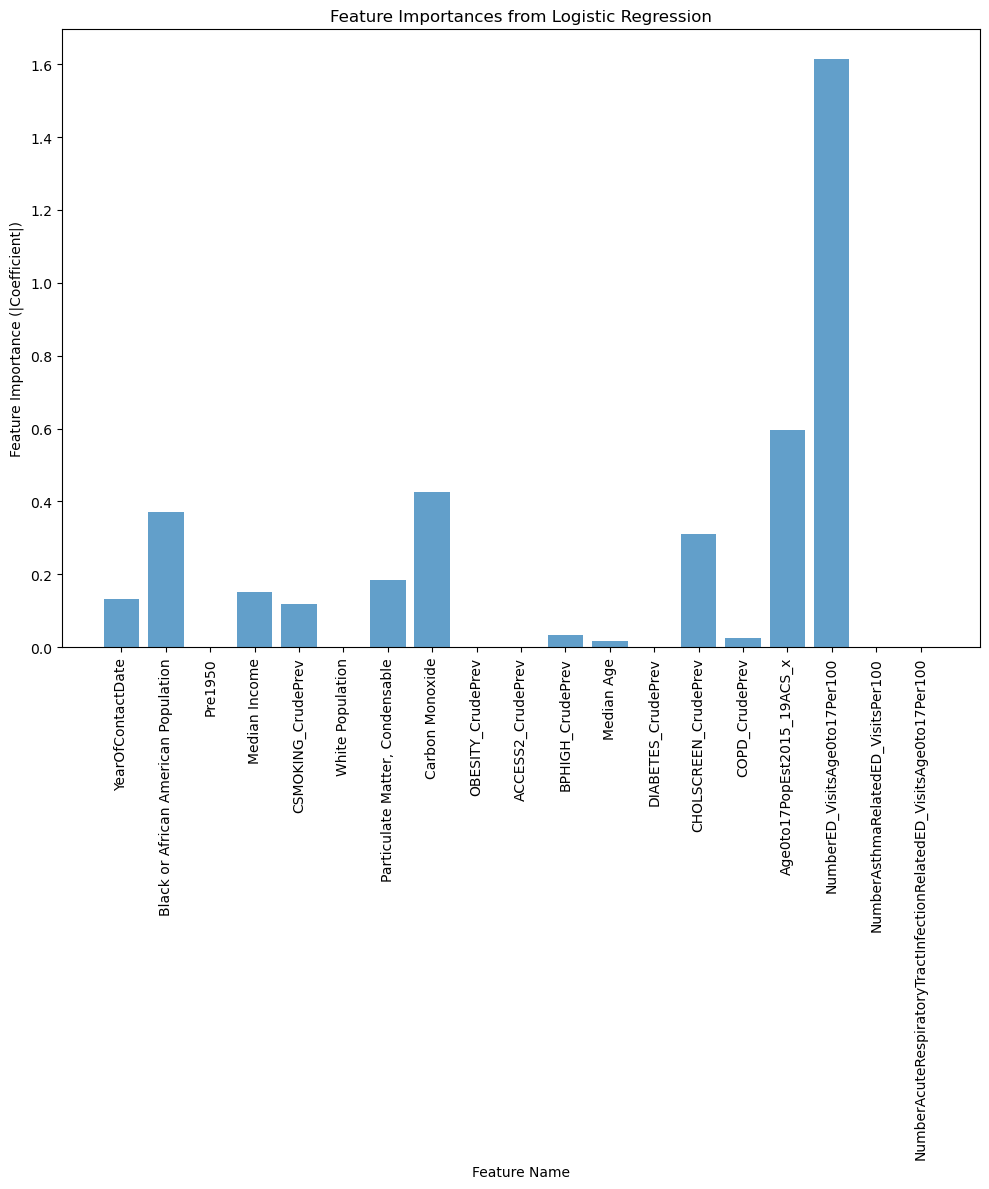

In [24]:
#feature importance for base model
# For binary classification, coef_ is shape (1, n_features)
# For multiclass, coef_ is (n_classes, n_features)
coefs = best_model.named_steps['classifier'].coef_

# If multiclass, take mean of absolute value across classes
if coefs.shape[0] > 1:
    importances01 = np.mean(np.abs(coefs), axis=0)
else:
    importances01 = np.abs(coefs[0])

# Print feature importances
for feature, importance in zip(X_train.columns, importances01):
    print(f"{feature}: {importance}")

# Plot feature importances
plt.figure(figsize=(10, 12))
x = np.arange(len(X_train.columns))
plt.bar(x, importances01, alpha=0.7)
plt.xticks(x, X_train.columns, rotation=90)
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance (|Coefficient|)')
plt.title('Feature Importances from Logistic Regression')
plt.tight_layout()
plt.show()

YearOfContactDate: 0.00037627845801784264
Black or African American Population: 0.0009977901663387931
Pre1950: 3.5058922220378326e-05
Median Income: 8.705074677777251e-06
CSMOKING_CrudePrev: 8.555656491312784e-05
White Population: 0.00027290828179229613
Particulate Matter, Condensable: 0.004290853316329064
Carbon Monoxide: 0.0006488256983801019
OBESITY_CrudePrev: 0.00020472478477076076
ACCESS2_CrudePrev: 0.001283570115111853
BPHIGH_CrudePrev: 8.296391606495887e-05
Median Age: 0.00019063017182422486
DIABETES_CrudePrev: 0.00016166662592486517
CHOLSCREEN_CrudePrev: 0.0032750196803981806
COPD_CrudePrev: 0.0001394949140074364
Age0to17PopEst2015_19ACS_x: 0.0036577776276119195
NumberED_VisitsAge0to17Per100: 0.028874668185237637
NumberAsthmaRelatedED_VisitsPer100: 7.194868393038113e-05
NumberAcuteRespiratoryTractInfectionRelatedED_VisitsAge0to17Per100: 0.004484778574082175


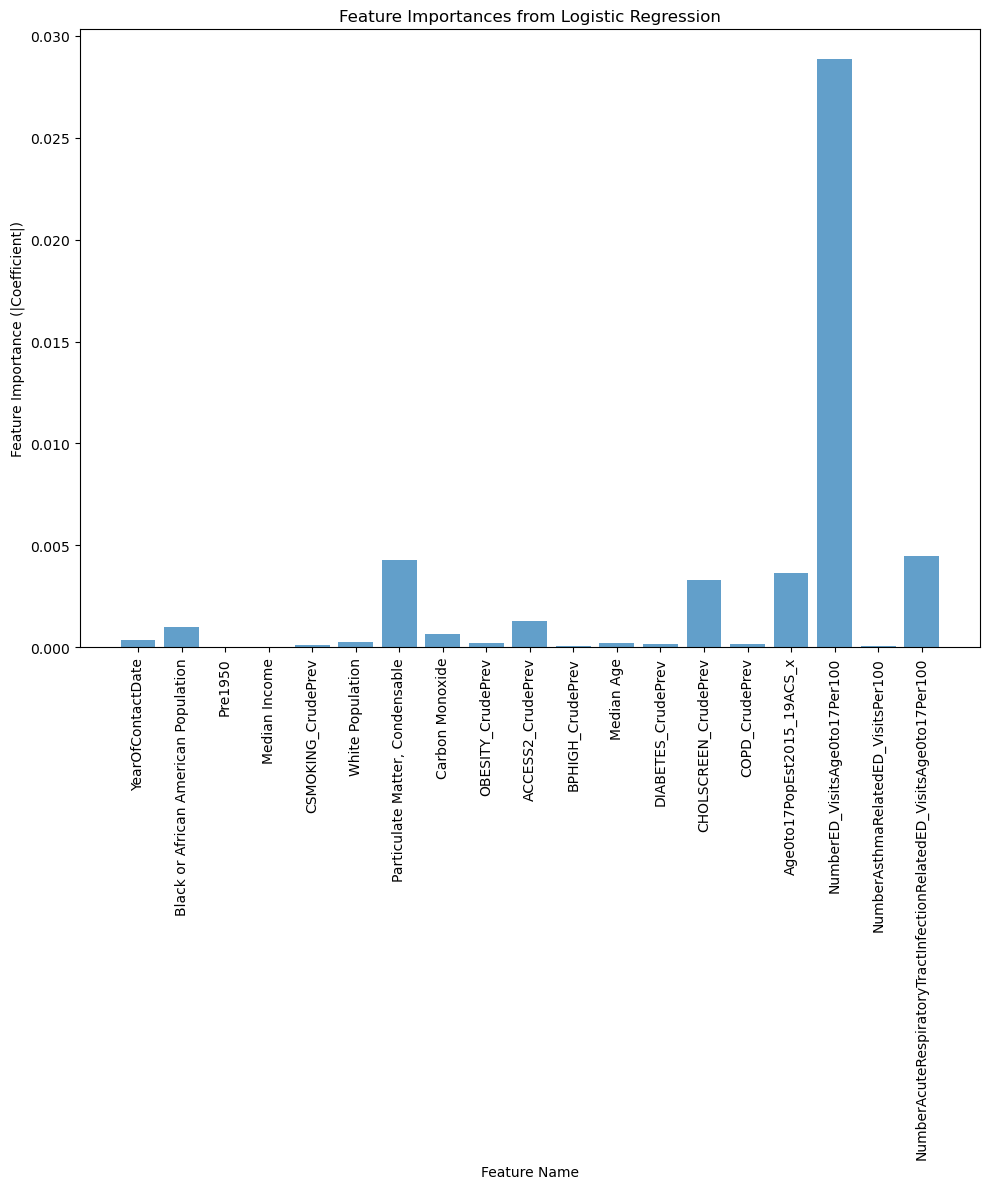

In [25]:
#feature importance for SMOTE
coefs2 = clf_smote.coef_

# If multiclass, take mean of absolute value across classes
if coefs2.shape[0] > 1:
    importances02 = np.mean(np.abs(coefs2), axis=0)
else:
    importances02 = np.abs(coefs2[0])

# Print feature importances
for feature, importance in zip(X_train.columns, importances02):
    print(f"{feature}: {importance}")

# Plot feature importances
plt.figure(figsize=(10, 12))
x = np.arange(len(X_train.columns))
plt.bar(x, importances02, alpha=0.7)
plt.xticks(x, X_train.columns, rotation=90)
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance (|Coefficient|)')
plt.title('Feature Importances from Logistic Regression')
plt.tight_layout()
plt.show()

YearOfContactDate: 0.13301511696861937
Black or African American Population: 0.36975393310755084
Pre1950: 0.0
Median Income: 0.15178643116611948
CSMOKING_CrudePrev: 0.11941482315741067
White Population: 0.0
Particulate Matter, Condensable: 0.1854496194288239
Carbon Monoxide: 0.42678731146256205
OBESITY_CrudePrev: 0.0
ACCESS2_CrudePrev: 0.0
BPHIGH_CrudePrev: 0.033145787175786014
Median Age: 0.016371680766133136
DIABETES_CrudePrev: 0.0
CHOLSCREEN_CrudePrev: 0.3109851669981354
COPD_CrudePrev: 0.025335468801514084
Age0to17PopEst2015_19ACS_x: 0.5973147221300287
NumberED_VisitsAge0to17Per100: 1.6150146192935537
NumberAsthmaRelatedED_VisitsPer100: 0.0
NumberAcuteRespiratoryTractInfectionRelatedED_VisitsAge0to17Per100: 0.0


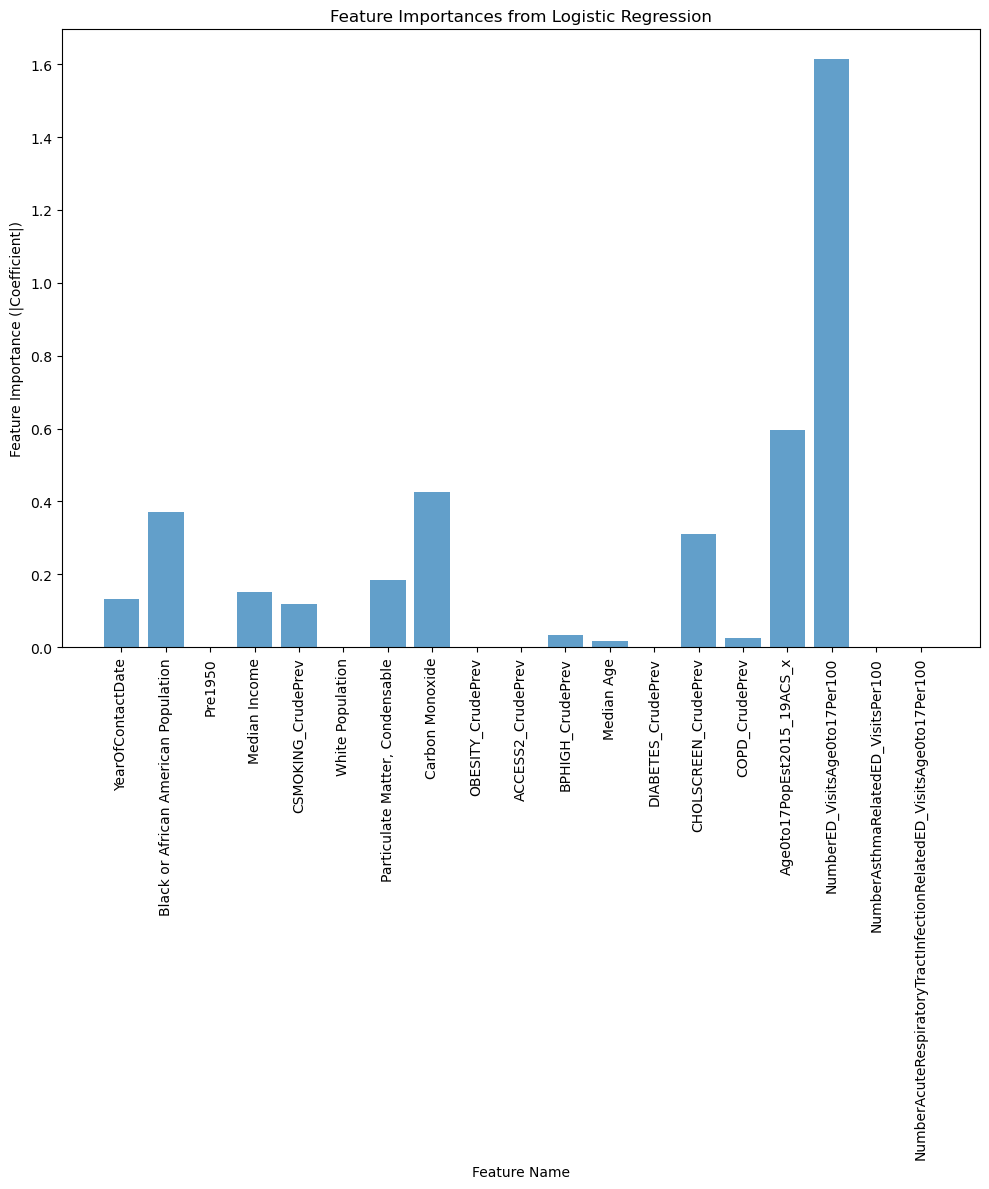

In [26]:
#feature importance for SMOTE + RUS
coefs3 = clf_rus.named_steps['classifier'].coef_

# If multiclass, take mean of absolute value across classes
if coefs2.shape[0] > 1:
    importances03 = np.mean(np.abs(coefs3), axis=0)
else:
    importances03 = np.abs(coefs3[0])

# Print feature importances
for feature, importance in zip(X_train.columns, importances03):
    print(f"{feature}: {importance}")

# Plot feature importances
plt.figure(figsize=(10, 12))
x = np.arange(len(X_train.columns))
plt.bar(x, importances03, alpha=0.7)
plt.xticks(x, X_train.columns, rotation=90)
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance (|Coefficient|)')
plt.title('Feature Importances from Logistic Regression')
plt.tight_layout()
plt.show()

# Model 2: Random Forest

In [27]:
#Creating modeling pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [28]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2']
}

# Grid search
rf = RandomForestClassifier(random_state = 15)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = tscv, scoring = 'accuracy', n_jobs = -1, verbose = 1)

# Fit model
grid_search.fit(X, y)

# Extract best model and params
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Fitting 4 folds for each of 32 candidates, totalling 128 fits
Best hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


In [29]:
# Lists for storing metrics
accuracy_list = []
precision_list = []
recall_list = []
fnr_list = []
confusion_matrices = []

# Loop through TimeSeriesSplit
for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = RandomForestClassifier(**best_params, random_state=42)
    model.fit(X_train, y_train)

    # y_pred = model.predict(X_test)
    # Abandoning predict() in favor of a different threshold to try and reduce FNR
    y_proba = model.predict_proba(X_test)[:, 1]
    custom_threshold = 0.3
    y_pred = (y_proba >= custom_threshold).astype(int)

    # Metrics
    accuracy_list.append(accuracy_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred, zero_division = 0))
    recall_list.append(recall_score(y_test, y_pred, zero_division = 0))
    confusion_matrices.append(confusion_matrix(y_test, y_pred))

# Report average metrics
print("Average Accuracy:", np.mean(accuracy_list))
print("Average Precision:", np.mean(precision_list))
print("Average Recall:", np.mean(recall_list))

# Confusion matrix from the last fold
print("\nConfusion Matrix (last fold):\n", confusion_matrices[-1])

Average Accuracy: 0.837620578778135
Average Precision: 0.5844311299505968
Average Recall: 0.707942165894111

Confusion Matrix (last fold):
 [[208  40]
 [  7  56]]


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Per-fold results:
   accuracy  precision    recall
0  0.768489      0.464  0.920635

Average performance:
accuracy     0.768489
precision    0.464000
recall       0.920635
dtype: float64

Average Feature Importances:
                                              Feature  AvgImportance
15                         Age0to17PopEst2015_19ACS_x       0.095277
16                      NumberED_VisitsAge0to17Per100       0.092444
7                                     Carbon Monoxide       0.069019
5                                    White Population       0.068095
6                     Particulate Matter, Condensable       0.062114
18  NumberAcuteRespiratoryTractInfectionRelatedED_...       0.060310
8                                   OBESITY_CrudePrev       0.057256
17                 NumberAsthmaRelatedED_VisitsPer100       0.055635
3                                       Median Income       0.055175
13                              

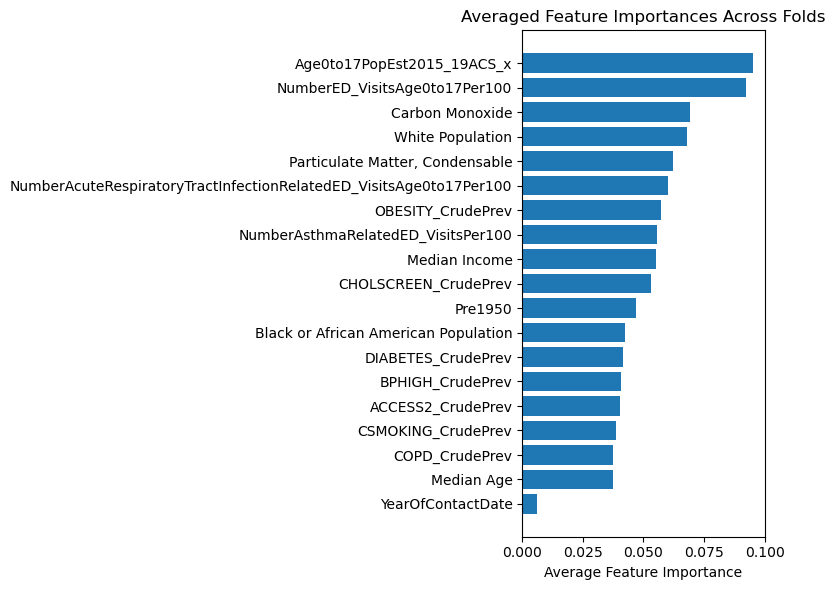

In [30]:
# Track metrics and feature importances
all_metrics = []
importances = []
# Random undersampling on training data
rus = RandomUnderSampler(random_state = 15)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

# Grid search
rf = RandomForestClassifier(random_state = 15)
grid = GridSearchCV(rf, param_grid, cv = 3, scoring = 'accuracy', n_jobs = -1, verbose = 1)
grid.fit(X_train_rus, y_train_rus)
best_rf = grid.best_estimator_

# Change threshold
y_proba = best_rf.predict_proba(X_test)[:, 1]
custom_threshold = 0.4
y_pred = (y_proba >= custom_threshold).astype(int)

# Predict and evaluate
# y_pred = best_rf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

all_metrics.append({
    'accuracy': acc,
    'precision': prec,
    'recall': rec,
    'confusion_matrix': cm,
    'best_params': grid.best_params_
})

# Store feature importances
importances.append(best_rf.feature_importances_)

# Average feature importances
avg_importance = np.mean(importances, axis = 0)
feat_importance = pd.DataFrame({
    'Feature': X.columns,
    'AvgImportance': avg_importance
}).sort_values(by='AvgImportance', ascending = False)

# Print results
metrics_df = pd.DataFrame(all_metrics)
print("Per-fold results:")
print(metrics_df[['accuracy', 'precision', 'recall']])
print("\nAverage performance:")
print(metrics_df[['accuracy', 'precision', 'recall']].mean())

print("\nAverage Feature Importances:")
print(feat_importance)

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.barh(feat_importance['Feature'], feat_importance['AvgImportance'])
plt.xlabel('Average Feature Importance')
plt.title('Averaged Feature Importances Across Folds')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

                                              Feature  MeanImportance
16                      NumberED_VisitsAge0to17Per100        0.123005
18  NumberAcuteRespiratoryTractInfectionRelatedED_...        0.077204
17                 NumberAsthmaRelatedED_VisitsPer100        0.074046
15                         Age0to17PopEst2015_19ACS_x        0.070602
6                     Particulate Matter, Condensable        0.065347
7                                     Carbon Monoxide        0.061132
5                                    White Population        0.054093
3                                       Median Income        0.051517
8                                   OBESITY_CrudePrev        0.048335
11                                         Median Age        0.044453
14                                     COPD_CrudePrev        0.044153
1                Black or African American Population        0.043038
12                                 DIABETES_CrudePrev        0.042990
10                  

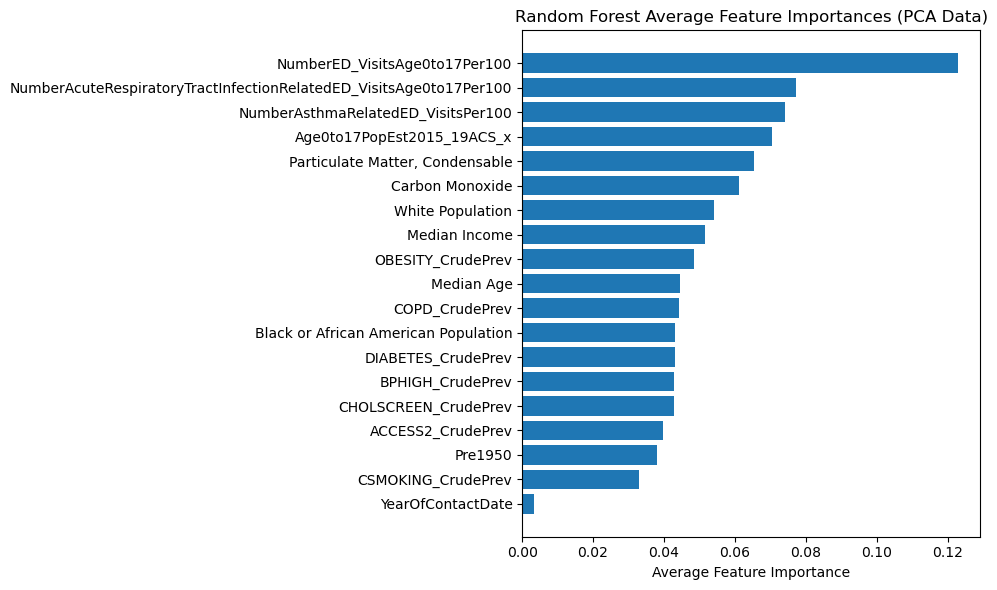

In [31]:
# Train model across folds and get average importances
importances_list = []

for train_idx, test_idx in tscv.split(X):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]

    model = RandomForestClassifier(**best_params, random_state = 15)
    model.fit(X_train, y_train)
    importances_list.append(model.feature_importances_)

# Aggregate and display
importances_array = np.array(importances_list)
mean_importances = np.mean(importances_array, axis = 0)

feat_importance = pd.DataFrame({
    'Feature': X.columns,
    'MeanImportance': mean_importances
}).sort_values(by='MeanImportance', ascending=False)

print(feat_importance)

# Visualize importances
plt.figure(figsize = (10, 6))
plt.barh(feat_importance['Feature'], feat_importance['MeanImportance'])
plt.xlabel('Average Feature Importance')
plt.title('Random Forest Average Feature Importances (PCA Data)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Model 3: XG Boost Model

In [32]:
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42))
])

In [33]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200, 500],
    'classifier__learning_rate':[0.1,0.4],
    'classifier__max_depth': [3, 6, 10, None],
    'classifier__min_child_weight': [1,3,7],
    'classifier__gamma': [0, 3, 5],
    'classifier__subsample': [0.5,1.0],
    'classifier__reg_lambda': [1, 5],
    'classifier__reg_alpha': [0, 1]
}


In [34]:
#grid_search
grid_search = GridSearchCV (
    estimator  = model_pipeline,
    param_grid = param_grid,  # Use demo_param_grid for quicker execution
            cv = tscv,
    #scoring='precision_recall_curve',
         refit = 'PR_AUC',  # Refit based on PR AUC
        n_jobs = -1,
       verbose = 2,
    return_train_score=True,
    scoring={
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'roc_auc': 'roc_auc',
        'PR_AUC': 'average_precision'  # PR AUC score
    }
)

In [35]:
#run model
print("\nStarting grid search...")
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print best parameters and score
print("\nBest parameters:")
print(grid_search.best_params_)
print(f"\nBest cross-validation score: {grid_search.best_score_:.4f}")

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate on test set
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("\nTest Set Evaluation:")
print(classification_report(y_test, y_pred))


Starting grid search...
Fitting 4 folds for each of 2304 candidates, totalling 9216 fits

Best parameters:
{'classifier__gamma': 0, 'classifier__learning_rate': 0.4, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__n_estimators': 200, 'classifier__reg_alpha': 1, 'classifier__reg_lambda': 1, 'classifier__subsample': 1.0}

Best cross-validation score: 0.7660

Test Set Evaluation:
              precision    recall  f1-score   support

       False       0.95      0.91      0.93       248
        True       0.70      0.81      0.75        63

    accuracy                           0.89       311
   macro avg       0.82      0.86      0.84       311
weighted avg       0.90      0.89      0.89       311



Text(0.5, 1.0, 'Confusion Matrix')

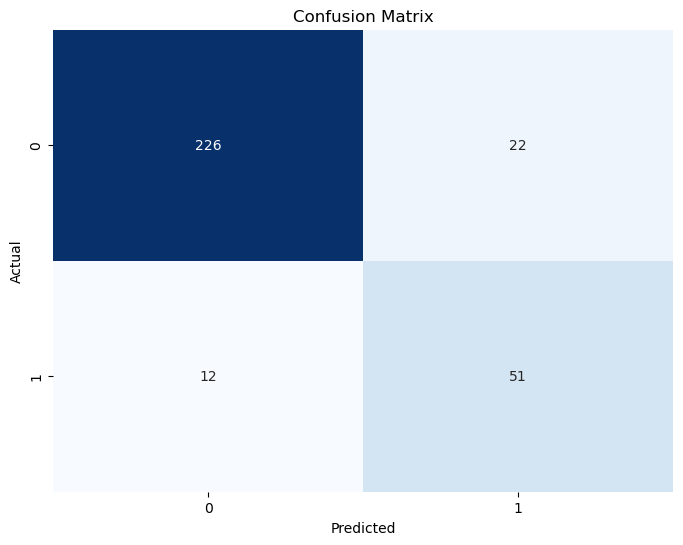

In [36]:
#Confusion Matrix shows good performance
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

In [37]:
#Calculating ROC AUC, also quite good
roc_auc = roc_auc_score(y_test, y_prob)
roc_auc

0.9454045058883769

In [38]:
#Precision Recall Curve and AUC also good
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)
pr_auc

0.8220300206928831

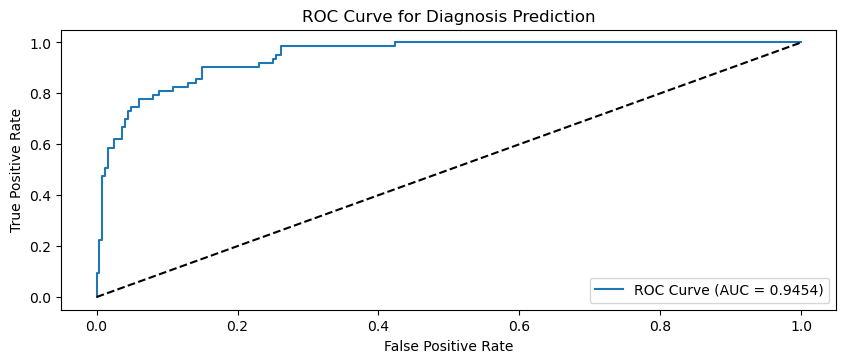

In [39]:
#Plotting ROC curve
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Diagnosis Prediction')
plt.legend(loc='lower right')

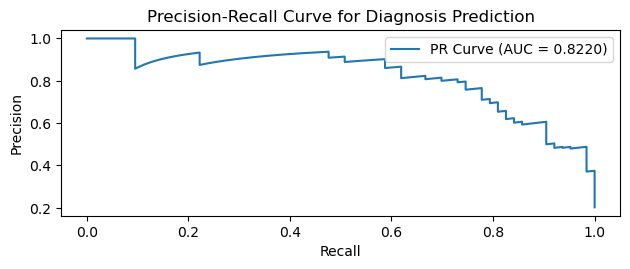

In [40]:
#Plotting precision recall curve
plt.subplot(2, 1, 2)
plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Diagnosis Prediction')
plt.legend(loc='upper right')
plt.tight_layout()

In [41]:
def evaluate_model( msg, X_test, y_test, y_pred, y_proba ):
    w=18
    print(msg, '\n')
    cm = confusion_matrix(y_test, y_pred)
    print( cm ); print()
    print( f'%{w}s : %.4f' % ('Precision', precision_score(y_test, y_pred)))
    print( f'%{w}s : %.4f' % ('Recall', recall_score(y_test, y_pred)))
    print( f'%{w}s : %.4f' % ('AUC-ROC', roc_auc_score(y_test, y_prob)))
    print( f'%{w}s : %.4f' % ('Average Precision', average_precision_score( y_test, y_prob)))
    print()
    
evaluate_model('Baseline Model Performance', X_test, y_test, y_pred, y_prob)

Baseline Model Performance 

[[226  22]
 [ 12  51]]

         Precision : 0.6986
            Recall : 0.8095
           AUC-ROC : 0.9454
 Average Precision : 0.8241



In [42]:
# Now apply imbalanced-learn techniques

# 1. SMOTE (Oversampling)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check new class distribution
print(f"\nBefore SMOTE - Training examples: {len(X_train)}")
print(f"Class distribution: {np.bincount(y_train)}")

# Check new class distribution
print(f"\nAfter SMOTE - Training examples: {len(X_train_smote)}")
print(f"Class distribution: {np.bincount(y_train_smote)}")


Before SMOTE - Training examples: 1245
Class distribution: [905 340]

After SMOTE - Training examples: 1810
Class distribution: [905 905]


In [43]:
#train data after smote
xgb_smote = XGBClassifier(random_state=42)
xgb_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = xgb_smote.predict(X_test)
y_proba_smote = xgb_smote.predict_proba(X_test)

In [44]:
def evaluate_model( msg, X_test, y_test, y_pred, y_proba ):
    w=18
    print(msg, '\n')
    cm = confusion_matrix(y_test, y_pred)
    print( cm ); print()
    print( f'%{w}s : %.4f' % ('Precision', precision_score(y_test, y_pred)))
    print( f'%{w}s : %.4f' % ('Recall', recall_score(y_test, y_pred)))
    print( f'%{w}s : %.4f' % ('F1 Score', f1_score(y_test, y_pred)))
    print( f'%{w}s : %.4f' % ('AUC-ROC', roc_auc_score(y_test, y_proba[:,1])))
    print( f'%{w}s : %.4f' % ('Average Precision', average_precision_score( y_test, y_proba[:,1] )))
    print()
    
evaluate_model('SMOTE Model Performance', X_test, y_test, y_pred_smote, y_proba_smote)


SMOTE Model Performance 

[[221  27]
 [ 12  51]]

         Precision : 0.6538
            Recall : 0.8095
          F1 Score : 0.7234
           AUC-ROC : 0.9229
 Average Precision : 0.7959



In [45]:
#balancing the dataset (we have target value = 25% of dataset)
rus_2 = RandomUnderSampler(random_state=42)
X_train_rus_2, y_train_rus_2 = rus_2.fit_resample(X_train, y_train)

# Check new class distribution
print(f"\nAfter Undersampling - Training examples: {len(X_train_rus_2)}")
print(f"Class distribution: {np.bincount(y_train_rus_2)}")


After Undersampling - Training examples: 680
Class distribution: [340 340]


In [46]:
xgb_rus_2 = XGBClassifier(random_state=42)
xgb_rus_2.fit(X_train_rus_2, y_train_rus_2)
y_pred_rus_2 = xgb_rus_2.predict(X_test)
y_proba_rus_2 = xgb_rus_2.predict_proba(X_test)

In [47]:
evaluate_model('Undersample Model Performance', X_test, y_test, y_pred_rus_2, y_proba_rus_2 )

Undersample Model Performance 

[[208  40]
 [  7  56]]

         Precision : 0.5833
            Recall : 0.8889
          F1 Score : 0.7044
           AUC-ROC : 0.9264
 Average Precision : 0.7283



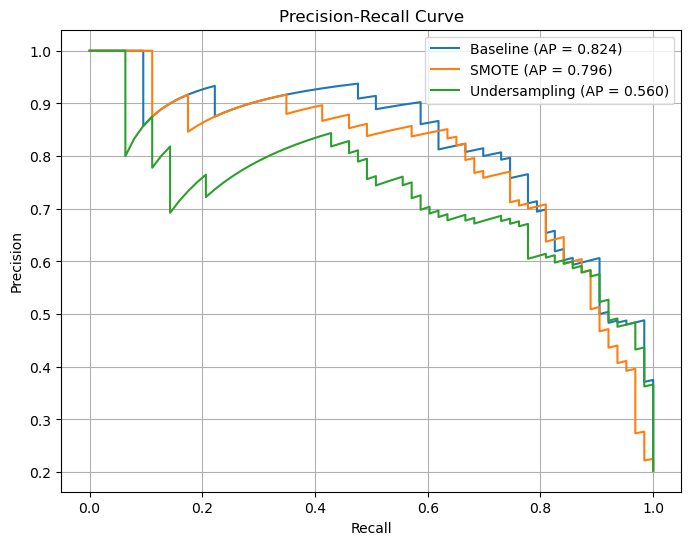

In [48]:
plt.figure(figsize=(8, 6))

# Baseline model PR curve
precision_base, recall_base, _ = precision_recall_curve(y_test, y_prob)
ap_base = average_precision_score(y_test, y_prob)
plt.plot(recall_base, precision_base, label=f'Baseline (AP = {ap_base:.3f})')

# SMOTE model PR curve
precision_smote, recall_smote, _ = precision_recall_curve(y_test, y_proba_smote[:, 1])
ap_smote = average_precision_score(y_test, y_proba_smote[:, 1])
plt.plot(recall_smote, precision_smote, label=f'SMOTE (AP = {ap_smote:.3f})')

# Undersampling model PR curve
precision_rus, recall_rus, _ = precision_recall_curve(y_test, y_proba_rus_2[:, 1])
ap_rus_2 = average_precision_score(y_test, y_proba_rus_2[:, 1])
plt.plot(recall_rus, precision_rus, label=f'Undersampling (AP = {ap_rus:.3f})')

plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

best model XGB:
YearOfContactDate: 0.006299082189798355
Black or African American Population: 0.03280669450759888
Pre1950: 0.0446711890399456
Median Income: 0.027664314955472946
CSMOKING_CrudePrev: 0.04152845963835716
White Population: 0.05077560618519783
Particulate Matter, Condensable: 0.07411167770624161
Carbon Monoxide: 0.06890523433685303
OBESITY_CrudePrev: 0.05296318233013153
ACCESS2_CrudePrev: 0.028855593875050545
BPHIGH_CrudePrev: 0.04327680543065071
Median Age: 0.01873892731964588
DIABETES_CrudePrev: 0.032755691558122635
CHOLSCREEN_CrudePrev: 0.05793450400233269
COPD_CrudePrev: 0.06265188753604889
Age0to17PopEst2015_19ACS_x: 0.08894431591033936
NumberED_VisitsAge0to17Per100: 0.20892059803009033
NumberAsthmaRelatedED_VisitsPer100: 0.028986060991883278
NumberAcuteRespiratoryTractInfectionRelatedED_VisitsAge0to17Per100: 0.029210174456238747
XGB smote:
YearOfContactDate: 0.12294550985097885
Black or African American Population: 0.045536477118730545
Pre1950: 0.03847785294055939
Med

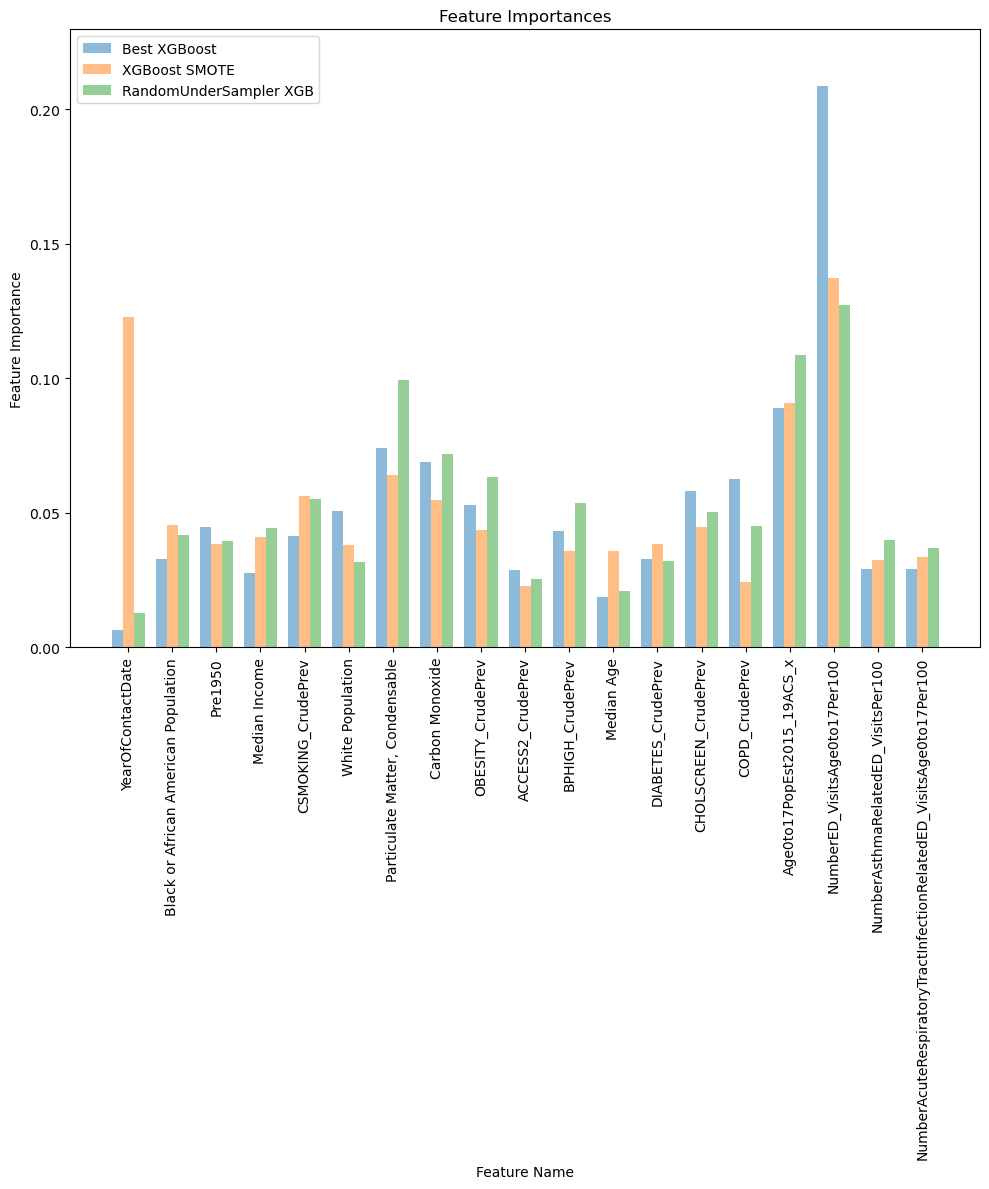

In [49]:
# Get feature importances
importances21 = best_model.named_steps['classifier'].feature_importances_
importances22 = xgb_smote.feature_importances_
importances23 = xgb_rus_2.feature_importances_
print("best model XGB:")
for feature, importance in zip(X_train.columns, importances21):
    print(f"{feature}: {importance}")

print("XGB smote:")
for feature, importance in zip(X_train.columns, importances22):
    print(f"{feature}: {importance}")

print("XGB smote:")
for feature, importance in zip(X_train.columns, importances22):
    print(f"{feature}: {importance}")


# Plot feature importances with feature names
plt.figure(figsize=(10, 12))
x = np.arange(len(X_train.columns))
width = 0.25

plt.bar(x - width, importances21, width, alpha=0.5, label='Best XGBoost')
plt.bar(x, importances22, width, alpha=0.5, label='XGBoost SMOTE')
plt.bar(x + width, importances23, width, alpha=0.5, label='RandomUnderSampler XGB')

plt.xticks(x, X_train.columns, rotation=90)
plt.xlabel('Feature Name')
plt.ylabel('Feature Importance')
plt.title('Feature Importances')
plt.legend()
plt.ylim([0, max(max(importances21), max(importances22), max(importances23)) * 1.1])  # Adjust y-axis scale
plt.tight_layout()
plt.show()